In [1]:
# import numpy and pandas
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi=False
import os

#import sklearn for cross validation|
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score,cross_validate

#import keras modules
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import keras
import keras.layers
from keras.layers import Layer 
import keras.initializers
from keras.models import Model, Sequential,load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Embedding, Lambda, Flatten, Multiply, multiply,dot, add,subtract
from keras.layers import Concatenate,concatenate,LeakyReLU,maximum,minimum
from keras.optimizers import Adam
from keras.regularizers import l2,l1
from keras.preprocessing import sequence
from keras.engine.topology import Layer, InputSpec

from keras.utils import plot_model
from IPython.display import SVG


from sklearn.metrics import precision_recall_curve, auc, roc_curve

#import rdkit
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

#fix the random seed
np.random.seed(5)

import pickle
import random



Using TensorFlow backend.


In [2]:
import scipy
from sklearn import preprocessing


In [3]:
import warnings

warnings.simplefilter('ignore')

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
GeneExpression_with_Symbol=pd.read_csv('/DAS_Storage4/ijjin/Study_2/CellLine/CCLE_expression_zscore.csv',index_col=0)
valid_gene_list=GeneExpression_with_Symbol.columns

GeneSet_List=[]
GeneSetFile='/DAS_Storage1/ijjin/Personal_studies/Drug-Cancer_reponse/geneset/c2.cp.kegg.v7.5.1.symbols.gmt'
with open(GeneSetFile) as f:
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter='\t')) #reads csv into a list of lists
    for row in data:
        GeneSet_List.append(row)

GeneSet_Dic={}
for GeneSet in GeneSet_List:
    GeneSet_Dic[GeneSet[0]]=GeneSet[2:]
GeneSet_Dic_withoutNA={}
for GeneSet in GeneSet_Dic:
    GeneSet_tmp=pd.Series(GeneSet_Dic[GeneSet])
    GeneSet_tmp=GeneSet_tmp[GeneSet_tmp.isin(valid_gene_list)]
    GeneSet_Dic_withoutNA[GeneSet]=GeneSet_tmp




In [5]:
K.clear_session()
def get_session(gpu_fraction=0.1):

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    return tf.Session(config=tf.ConfigProto(allow_soft_placement=True,gpu_options=gpu_options))

KTF.set_session(get_session())


2022-11-18 15:38:48.102406: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-11-18 15:38:48.139061: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2022-11-18 15:38:48.144324: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x259880b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-18 15:38:48.144364: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-18 15:38:48.152571: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-18 15:38:48.296992: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2598a130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-18 15:38:48.297064: I tensorflow/compiler/xla/s

In [6]:
def plcc_loss(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - r 

def aggregated_loss(y_true,y_pred):
    mse_value=tf.keras.metrics.mse(y_true,y_pred)
    pearson_loss=plcc_loss(y_true,y_pred)
    return mse_value+pearson_loss
    
    
def plcc_metric(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den


In [7]:
#relu
def Making_Model():
    #model_parameter=load_model('/DAS_Storage4/ijjin/Study_2/Single/NCI60_March22/Parameter/Model/220507_training_validation.hdf5',compile=False)

    #Make Model for each gene set, that consists of multiple genes_attention by built-in(2019/05/08)
    initializer = tf.keras.initializers.he_uniform()

    #Drug level
    Drug_feature_length=512
    Drug_Input=Input((Drug_feature_length,), dtype='float32', name='Drug_Input')
    Drug_Input=Input((Drug_feature_length,), dtype='float32')

    Drug_Dense1=Dense(256, name='Drug_Dense_1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense1=BatchNormalization()(Drug_Dense1)
    Drug_Dense1=Activation('relu', name='Drug_RELU_1')(Drug_Dense1)

    Drug_Dense2=Dense(128, name='Drug_Dense_2',kernel_initializer=initializer)(Drug_Dense1)
    Drug_Dense2=BatchNormalization()(Drug_Dense2)
    Drug_Dense2=Activation('relu', name='Drug_RELU_2')(Drug_Dense2)

    Drug_Dense_New1=Dense(128, name='Drug_Dense_New1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense_New1=BatchNormalization()(Drug_Dense_New1)
    Drug_Dense_New1=Activation('relu', name='Drug_RELU_New1')(Drug_Dense_New1)

    Drug_Dense_New2=Dense(32, name='Drug_Dense_New2',kernel_initializer=initializer)(Drug_Dense_New1)
    Drug_Dense_New2=BatchNormalization()(Drug_Dense_New2)
    Drug_Dense_New2=Activation('relu', name='Drug_RELU_New2')(Drug_Dense_New2)
    
    #Gene level
    GeneSet_Model=[]
    GeneSet_Input=[]
    for GeneSet in GeneSet_Dic_withoutNA.keys():
        Gene_Input=Input(shape=(len(GeneSet_Dic_withoutNA[GeneSet]),),dtype='float32', name=GeneSet+'_Input')
        
        Drug_effected_Model_for_Attention=[Gene_Input]
        Drug_Dense_Geneset=Dense(int(len(GeneSet_Dic_withoutNA[GeneSet])/4)+1,dtype='float32',name=GeneSet+'_Drug',kernel_initializer=initializer)(Drug_Dense_New2)
        Drug_Dense_Geneset=BatchNormalization(name=GeneSet+'_Drug_Batch')(Drug_Dense_Geneset)
        Drug_Dense_Geneset=Activation('relu', name=GeneSet+'Drug_RELU')(Drug_Dense_Geneset)
        Drug_effected_Model_for_Attention.append(Drug_Dense_Geneset) #Drug feature to attention layer
        Gene_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1,name=GeneSet+'_Concat')
        Gene_Attention = Dense(len(GeneSet_Dic_withoutNA[GeneSet]), activation='tanh', name=GeneSet+'_Attention_Dense',kernel_initializer=initializer)(Gene_Concat)
        Gene_Attention=Activation(activation='softmax', name=GeneSet+'_Attention_Softmax')(Gene_Attention)
        Attention_Dot=dot([Gene_Input,Gene_Attention],axes=1,name=GeneSet+'_Dot')
        Attention_Dot=BatchNormalization(name=GeneSet+'_BatchNormalized')(Attention_Dot)
        Attention_Dot=Activation('relu',name=GeneSet+'_RELU')(Attention_Dot)
        GeneSet_Model.append(Attention_Dot)
        GeneSet_Input.append(Gene_Input)

    Drug_effected_Model_for_Attention=GeneSet_Model.copy()
    
    
    Drug_Dense_Sample=Dense(int(len(GeneSet_Dic_withoutNA)/16)+1,dtype='float32',name='Sample_Drug_Dense',kernel_initializer=initializer)(Drug_Dense_New2)
    Drug_Dense_Sample=BatchNormalization(name=GeneSet+'Sample_Drug_Batch')(Drug_Dense_Sample)
    Drug_Dense_Sample=Activation('relu', name='Sample_Drug_ReLU')(Drug_Dense_Sample)    #Drug feature to attention layer
    Drug_effected_Model_for_Attention.append(Drug_Dense_Sample)
    
    GeneSet_Concat=concatenate(GeneSet_Model,axis=1, name='GeneSet_Concatenate')
    Drug_effected_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1, name='Drug_effected_Concatenate')
    Sample_Attention=Dense(len(GeneSet_Dic_withoutNA.keys()),activation='tanh', name='Sample_Attention_Dense',kernel_initializer=initializer)(Drug_effected_Concat)
    Sample_Attention=Activation(activation='softmax', name='Sample_Attention_Softmax')(Sample_Attention)
    Sample_Multiplied=multiply([GeneSet_Concat,Sample_Attention], name='Sample_Attention_Multiplied')
    Sample_Multiplied=BatchNormalization(name='Sample_Attention_BatchNormalized')(Sample_Multiplied)
    Sample_Multiplied=Activation('relu',name='Sample_Attention_Relu')(Sample_Multiplied)
    
    Input_for_model=[]
    for GeneSet_f in GeneSet_Input:
        Input_for_model.append(GeneSet_f)
    Input_for_model.append(Drug_Input)
    
    Dose_Input=Input((1,), dtype='float32', name='Dose_Input')
    Input_for_model.append(Dose_Input)

    Total_model=[Sample_Multiplied,Drug_Dense2]
    Model_Concat=concatenate(Total_model,axis=1, name='Total_Concatenate')
    Concated=Dense(128, name='Total_Dense')(Model_Concat)
    Concated=BatchNormalization(name='Total_BatchNormalized')(Concated)
    Concated=Activation(activation='relu', name='Total_RELU')(Concated)
    
    Final=Dense(32, name='Output_Dense1',kernel_initializer=initializer)(Concated)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU')(Final)
    Final=Dense(8,name='Output_Dense2',kernel_initializer=initializer)(Final)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU2')(Final)
    Final=Dense(2, name='Output_Dense3',kernel_initializer=initializer)(Final)    
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU3')(Final)
    
    Final_y_max=Dense(1, name='y_max',kernel_initializer=initializer)(Final)
    Final_y_min=Dense(1, name='y_min',kernel_initializer=initializer)(Final)
    Final_slope=Dense(1, name='slope',kernel_initializer=initializer)(Final)
    Final_IC50=Dense(1, name='IC50',kernel_initializer=initializer)(Final)

    Final_1=subtract([Dose_Input,Final_IC50],name='Final_1')
    Final_2=multiply([Final_slope,Final_1],name='Final_2')
    Final_negative=Lambda(lambda x:-1*x)(Final_2)
    Final_Sigmoid=Activation(activation='sigmoid',name='Final_Sigmoid')(Final_negative)
    Final_scale=subtract([Final_y_max,Final_y_min],name='Final_scale')
    Final_scale=Activation(activation='relu',name='Final_scale_activation')(Final_scale)
    Final_3=multiply([Final_scale,Final_Sigmoid],name='Final_3')
    Final_4=add([Final_3,Final_y_min],name='Final_4')
    model=Model(inputs=Input_for_model,outputs=Final_4)

    return model


In [8]:
model_monotherapy=Making_Model()
model_monotherapy.load_weights('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI_ALMANAC_mono/Result/221114_Frozen_Full/221114_Frozen_Full.hdf5')
model_monotherapy.compile(loss=aggregated_loss,optimizer=keras.optimizers.Adam(lr=0.01),metrics=[plcc_metric,'mean_squared_error'])
model_attention=Model(inputs=model_monotherapy.inputs,outputs=model_monotherapy.get_layer('Sample_Attention_Softmax').output)
model_activity=Model(inputs=model_monotherapy.inputs,outputs=model_monotherapy.get_layer('Sample_Attention_Multiplied').output)

In [9]:
NCI_ALMANAC_combination=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/20221115_NCI_ALMANAC_combination_valid_by_mono.csv',index_col=0)
NCI_ALMANAC_combination.CONC1=[np.around(x,5) for x in NCI_ALMANAC_combination.CONC1]
NCI_ALMANAC_combination.CONC2=[np.around(x,5) for x in NCI_ALMANAC_combination.CONC2]

In [10]:
NCI_ALMANAC_combination_with_parameter_filtered_2=NCI_ALMANAC_combination[NCI_ALMANAC_combination.PERCENTGROWTH<2.1]
NCI_ALMANAC_combination_with_parameter_filtered_2.CONC1=[np.around(x,5) for x in NCI_ALMANAC_combination_with_parameter_filtered_2.CONC1]
NCI_ALMANAC_combination_with_parameter_filtered_2.CONC2=[np.around(x,5) for x in NCI_ALMANAC_combination_with_parameter_filtered_2.CONC2]
NCI_ALMANAC_combination_good=NCI_ALMANAC_combination_with_parameter_filtered_2
NCI_ALMANAC_combination_sample=NCI_ALMANAC_combination_good.sample(frac=1)
NCI_ALMANAC_combination_sample=NCI_ALMANAC_combination_sample.reset_index(drop=True)
NCI60_ALMANAC_level_list=[]
scale=0.1
for i in range(int(2/scale)):
    NCI60_ALMANAC_level_df=NCI_ALMANAC_combination_sample[(NCI_ALMANAC_combination_sample.PERCENTGROWTH>i*scale)*(NCI_ALMANAC_combination_sample.PERCENTGROWTH<(i+1)*scale)]
    NCI60_ALMANAC_level_list.append(NCI60_ALMANAC_level_df)
len_min=min([len(df) for df in NCI60_ALMANAC_level_list])
NCI60_ALMANAC_level_list_new=[]
for df in NCI60_ALMANAC_level_list:
    scale_each=len_min/len(df)
    df_new=df.sample(frac=scale_each)
    NCI60_ALMANAC_level_list_new.append(df_new)
NCI_ALMANAC_balanced=pd.concat(NCI60_ALMANAC_level_list_new)

In [11]:
NCI_ALMANAC_mono=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_mono_valid.csv',index_col=0)

In [12]:
#Add monotherapy data
NCI_ALMANAC_mono_randomized=NCI_ALMANAC_mono.sample(frac=1)
NCI_ALMANAC_mono_randomized_level_list=[]
scale=0.1
for i in range(int(2/scale)):
    NCI_ALMANAC_mono_randomized_level_df=NCI_ALMANAC_mono_randomized[(NCI_ALMANAC_mono_randomized.PERCENTGROWTH>i*scale)*(NCI_ALMANAC_mono_randomized.PERCENTGROWTH<(i+1)*scale)]
    NCI_ALMANAC_mono_randomized_level_list.append(NCI_ALMANAC_mono_randomized_level_df)
len_min=min([len(df) for df in NCI_ALMANAC_mono_randomized_level_list])
NCI_ALMANAC_mono_randomized_level_list_new=[]
for df in NCI_ALMANAC_mono_randomized_level_list:
    scale_each=len_min/len(df)
    df_new=df.sample(frac=scale_each)
    NCI_ALMANAC_mono_randomized_level_list_new.append(df_new)
NCI_ALMANAC_mono_randomized_balanced=pd.concat(NCI_ALMANAC_mono_randomized_level_list_new)



In [13]:
NCI_ALMANAC_mono_drug_df=NCI_ALMANAC_mono_randomized.drop_duplicates(subset=['NSC'])[['NSC']]

In [14]:
NCI_monotherapy_df_list=[]
for idx,x in NCI_ALMANAC_mono_randomized_balanced.iterrows():
    nsc=x.NSC
    conc=x.CONC
    cellline=x.CellName
    viability=x.PERCENTGROWTH
    df_tmp=NCI_ALMANAC_mono_drug_df[NCI_ALMANAC_mono_drug_df.NSC!=nsc].sample(frac=1).copy()
    num_for_each_nsc=int(NCI_ALMANAC_balanced.shape[0]/NCI_ALMANAC_mono_randomized_balanced.shape[0])
    df_tmp=df_tmp.iloc[:num_for_each_nsc]
    df_tmp.columns=['NSC1']
    df_tmp['CONC1']=-12
    df_tmp['NSC2']=nsc
    df_tmp['CONC2']=conc
    df_tmp['CellName']=cellline
    df_tmp['PERCENTGROWTH']=viability
    NCI_monotherapy_df_list.append(df_tmp)
NCI_monotherapy_df=pd.concat(NCI_monotherapy_df_list)

In [15]:
NCI_ALMANAC_balanced=pd.concat([NCI_ALMANAC_balanced,NCI_monotherapy_df],axis=0)

In [16]:
NCI_ALMANAC_balanced_copy=NCI_ALMANAC_balanced[['NSC2','CONC2','NSC1','CONC1','CellName','PERCENTGROWTH']]
NCI_ALMANAC_balanced_copy.columns=NCI_ALMANAC_balanced.columns
NCI_ALMANAC_balanced=pd.concat([NCI_ALMANAC_balanced,NCI_ALMANAC_balanced_copy],axis=0)

NCI_ALMANAC_combination_sample=NCI_ALMANAC_balanced.sample(frac=1)
NCI_ALMANAC_combination_sample=NCI_ALMANAC_combination_sample.reset_index(drop=True)

In [17]:
NCI_ALMANAC_combination=NCI_ALMANAC_combination_sample

In [18]:
NCI_ALMANAC_combination_drug1=NCI_ALMANAC_combination[['NSC1','CellName']]
NCI_ALMANAC_combination_drug2=NCI_ALMANAC_combination[['NSC2','CellName']]

identifier_drug1=NCI_ALMANAC_combination_drug1.drop_duplicates()
identifier_drug2=NCI_ALMANAC_combination_drug2.drop_duplicates()

identifier_drug1.columns=['NSC','CellName']
identifier_drug2.columns=['NSC','CellName']

identifier_drugs=pd.concat([identifier_drug1,identifier_drug2]).drop_duplicates()
identifier_drugs['CONC']=2
identifier_drugs=identifier_drugs.reset_index(drop=True)

#Cell line feature
X_origin=[pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/CellLine/Input/'+str(x)+'.csv',index_col=0) for x in range(len(GeneSet_Dic_withoutNA))]
X_origin=[df.loc[identifier_drugs.CellName] for df in X_origin]
#Drug feature
Drug=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Drug/NCI60_compound_Morgan512.csv',index_col=0)
X_origin.append(Drug.loc[identifier_drugs.NSC])
#Dose feature
X_origin.append(identifier_drugs[['CONC']])

attention_results=model_attention.predict(X_origin)
attention_df=pd.DataFrame(attention_results)
attention_df.index=pd.MultiIndex.from_arrays([identifier_drugs.NSC,identifier_drugs.CellName])
attention_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Input/221118_Full_with_monotherapy/pathway_attention_with_MultiIndex.csv')

activity_results=model_activity.predict(X_origin)
activity_df=pd.DataFrame(activity_results)
activity_df.index=pd.MultiIndex.from_arrays([identifier_drugs.NSC,identifier_drugs.CellName])
activity_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Input/221118_Full_with_monotherapy/pathway_activity_with_MultiIndex.csv')

2022-11-18 15:40:42.761292: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


In [19]:
NCI_ALMANAC_combination_drug1=NCI_ALMANAC_combination[['NSC1','CONC1','CellName']]
NCI_ALMANAC_combination_drug2=NCI_ALMANAC_combination[['NSC2','CONC2','CellName']]

identifier_drug1=NCI_ALMANAC_combination_drug1.drop_duplicates()
identifier_drug1.CONC1=[np.around(x,5) for x in identifier_drug1.CONC1]
identifier_drug2=NCI_ALMANAC_combination_drug2.drop_duplicates()
identifier_drug2.CONC2=[np.around(x,5) for x in identifier_drug2.CONC2]

identifier_drug1.columns=['NSC','CONC','CellName']
identifier_drug2.columns=['NSC','CONC','CellName']
identifier_drugs=pd.concat([identifier_drug1,identifier_drug2]).drop_duplicates()

#Cell line feature
X_origin=[pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/CellLine/Input/'+str(x)+'.csv',index_col=0) for x in range(len(GeneSet_Dic_withoutNA))]
X_origin=[df.loc[identifier_drugs.CellName] for df in X_origin]
#Drug feature
Drug=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Drug/NCI60_compound_Morgan512.csv',index_col=0)
X_origin.append(Drug.loc[identifier_drugs.NSC])
#Dose feature
X_origin.append(identifier_drugs[['CONC']])

predicted_viability=model_monotherapy.predict(X_origin)
predicted_viability=[x[0] for x in predicted_viability]
identifier_drugs['predicted_viability']=predicted_viability
identifier_drugs.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Input/221118_Full_with_monotherapy/Predicted_viability.csv')

In [20]:
K.clear_session()
def get_session(gpu_fraction=0.1):

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    return tf.Session(config=tf.ConfigProto(allow_soft_placement=True,gpu_options=gpu_options))

KTF.set_session(get_session())


2022-11-18 15:42:43.401210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN V major: 7 minor: 0 memoryClockRate(GHz): 1.455
pciBusID: 0000:3b:00.0
2022-11-18 15:42:43.401673: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-11-18 15:42:43.401732: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-11-18 15:42:43.401781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-11-18 15:42:43.401837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-11-18 15:42:43.401881: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2022-11-18 15:42:43.401930: I tensorflow/stream_executor/plat

In [186]:
#Cell line feature
attention_df=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Input/221118_Full_with_monotherapy/pathway_attention_with_MultiIndex.csv',index_col=[0,1])
activity_df=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Input/221118_Full_with_monotherapy/pathway_activity_with_MultiIndex.csv',index_col=[0,1])
#attention_df=pd.read_csv('/DAS_Storage4/ijjin/Study_2/Synergy/Input/220510_Parameter_supported_fully_Undersampling_leveled_Full_without_Freezing/pathway_activity_with_MultiIndex.csv',index_col=[0,1])
#Drug featurea
viability_df=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Input/221118_Full_with_monotherapy/Predicted_viability.csv',index_col=[1,2,3])
viability_df=viability_df[['predicted_viability']]

viability_df_reset=viability_df.reset_index()
viability_df_reset['CONC']=[np.around(x,5) for x in viability_df_reset['CONC']]
viability_df_reset.index=pd.MultiIndex.from_arrays([viability_df_reset.NSC,viability_df_reset.CONC,viability_df_reset.CellName])
viability_df_reset=viability_df_reset[['predicted_viability']]
viability_df=viability_df_reset

In [22]:
class ECHiDNA_DataGenerator(keras.utils.Sequence):
    def __init__(self, idxs, batch_size=1024, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.idxs = idxs
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.idxs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        idxs_tmp = [self.idxs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(idxs_tmp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.idxs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # Generate data
        NCI_ALMANAC_gen=NCI_ALMANAC_combination_sample.iloc[idxs_tmp]
        MultiIndex_for_attention_drug1=pd.MultiIndex.from_arrays([NCI_ALMANAC_gen['NSC1'],NCI_ALMANAC_gen['CellName']])
        X_attention_drug1=activity_df.loc[MultiIndex_for_attention_drug1]
        X_attention_drug1=X_attention_drug1.reset_index(drop=True)
        MultiIndex_for_attention_drug2=pd.MultiIndex.from_arrays([NCI_ALMANAC_gen['NSC2'],NCI_ALMANAC_gen['CellName']])
        X_attention_drug2=activity_df.loc[MultiIndex_for_attention_drug2]
        X_attention_drug2=X_attention_drug2.reset_index(drop=True)
        #X_attention=pd.concat([X_attention_drug1,X_attention_drug2],axis=1)
       
        MultiIndex_for_viability_drug1=pd.MultiIndex.from_arrays([NCI_ALMANAC_gen['NSC1'],NCI_ALMANAC_gen['CONC1'],NCI_ALMANAC_gen['CellName']])
        X_viability_drug1=viability_df.loc[MultiIndex_for_viability_drug1]
        X_viability_drug1=X_viability_drug1.reset_index(drop=True)
        MultiIndex_for_viability_drug2=pd.MultiIndex.from_arrays([NCI_ALMANAC_gen['NSC2'],NCI_ALMANAC_gen['CONC2'],NCI_ALMANAC_gen['CellName']])
        X_viability_drug2=viability_df.loc[MultiIndex_for_viability_drug2]
        X_viability_drug2=X_viability_drug2.reset_index(drop=True)
        #X_viability=pd.concat([X_viability_drug1,X_viability_drug2],axis=1)
        
        X_origin_tmp=[X_attention_drug1,X_attention_drug2,X_viability_drug1,X_viability_drug2]
        Y_origin_tmp=NCI_ALMANAC_gen['PERCENTGROWTH']
        Y_origin_tmp=Y_origin_tmp.reset_index(drop=True)

        return X_origin_tmp, Y_origin_tmp

In [24]:
NCI_ALMANAC_combination_sample.CONC1=[np.around(x,5) for x in NCI_ALMANAC_combination_sample.CONC1]
NCI_ALMANAC_combination_sample.CONC2=[np.around(x,5) for x in NCI_ALMANAC_combination_sample.CONC2]

In [25]:
NCI_ALMANAC_combination_sample

,NSC1,CONC1,NSC2,CONC2,CellName,PERCENTGROWTH
0,761432,-1.30103,19893,-12.00000,NIHOVCAR3,0.52562
1,409962,2.69897,609699,-12.00000,HOP92,0.33520
2,754230,-3.22185,49842,-2.52288,ACHN,1.95200
3,32065,1.30103,24559,0.00000,OVCAR8,0.57560
4,63878,1.00000,755986,-12.00000,CAKI1,1.05730
...,...,...,...,...,...,...
152395,740,-0.52288,747974,-2.00000,NCIH460,1.35952
152396,733504,-0.30103,102816,-12.00000,SKMEL28,1.46986
152397,45388,1.69897,608210,0.00000,NCIH522,0.71312
152398,760766,-1.69897,256942,0.00000,UACC257,0.54217


<AxesSubplot:xlabel='PERCENTGROWTH', ylabel='Density'>

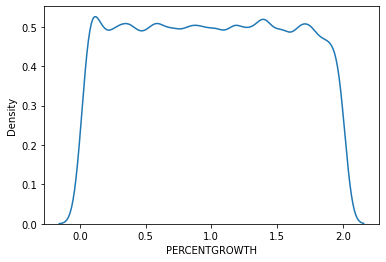

In [26]:
sns.kdeplot(NCI_ALMANAC_combination_sample.PERCENTGROWTH)

In [27]:
NCI_ALMANAC_combination_sample.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Training/Full/Full.csv')

In [187]:
full_generator=ECHiDNA_DataGenerator(NCI_ALMANAC_combination_sample.index)

In [28]:
K.clear_session()
def get_session(gpu_fraction=0.1):

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    return tf.Session(config=tf.ConfigProto(allow_soft_placement=True,gpu_options=gpu_options))

KTF.set_session(get_session())


2022-11-18 15:44:27.156240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN V major: 7 minor: 0 memoryClockRate(GHz): 1.455
pciBusID: 0000:3b:00.0
2022-11-18 15:44:27.156542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-11-18 15:44:27.156582: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-11-18 15:44:27.156605: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-11-18 15:44:27.156626: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-11-18 15:44:27.156647: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2022-11-18 15:44:27.156669: I tensorflow/stream_executor/plat

In [181]:
#221121_Siamese_Test_with_Factorization Machine_Viability(0.9265251159667969)
def Making_Model():
    #Make Model for each gene set, that consists of multiple genes_attention by built-in(2019/05/08)
    
    initializer = tf.keras.initializers.he_uniform()

    #Drug level
    Pathway_length=186
    Attention_Drug1=Input((Pathway_length,),name='Attention_Drug1')
    Attention_Drug2=Input((Pathway_length,),name='Attention_Drug2')
    
    Subtracted_Attention=subtract([Attention_Drug1,Attention_Drug2])
    Attention_Drug_Attention=Dense(Pathway_length,kernel_initializer=initializer)(Subtracted_Attention)
    
    Attention_Drug_multiplied=multiply([Subtracted_Attention,Attention_Drug_Attention])
    
    Dense_Attention_for_Viability1=Dense(128,kernel_initializer=initializer)(Attention_Drug_multiplied)
    #Dense_Attention_for_Viability1=BatchNormalization()(Dense_Attention_for_Viability1)
    Dense_Attention_for_Viability1=Activation('relu')(Dense_Attention_for_Viability1)
    
    Dense_Attention_for_Viability1=Dense(32,kernel_initializer=initializer)(Dense_Attention_for_Viability1)
    #Dense_Attention_for_Viability1=BatchNormalization()(Dense_Attention_for_Viability1)
    Dense_Attention_for_Viability1=Activation('relu')(Dense_Attention_for_Viability1)
    
    Dense_Attention_for_Viability1=Dense(8,kernel_initializer=initializer)(Dense_Attention_for_Viability1)
    #Dense_Attention_for_Viability1=BatchNormalization()(Dense_Attention_for_Viability1)
    Dense_Attention_for_Viability1=Activation('relu')(Dense_Attention_for_Viability1)
    
    Dense_Attention_for_Viability1=Dense(2, name='Synergy_Viability1',kernel_initializer=initializer)(Dense_Attention_for_Viability1)
    Dense_Attention_for_Viability1=Activation('tanh', name='Attention_Individual')(Dense_Attention_for_Viability1)

    """
    Dense_Attention_for_Viability2=Dense(256,kernel_initializer=initializer)(Attention_Drug_multiplied)
    Dense_Attention_for_Viability2=Activation('relu')(Dense_Attention_for_Viability2)
    
    Dense_Attention_for_Viability2=Dense(16,kernel_initializer=initializer)(Dense_Attention_for_Viability2)
    Dense_Attention_for_Viability2=Activation('relu')(Dense_Attention_for_Viability2)
    
    Dense_Attention_for_Viability2=Dense(1, name='Synergy_Viability2',kernel_initializer=initializer)(Dense_Attention_for_Viability2)
    Dense_Attention_for_Viability2=Activation('tanh', name='Synergy_Viability2_tanh')(Dense_Attention_for_Viability2)
    

    Dense_Attention_for_Viability3=Dense(256,kernel_initializer=initializer)(Attention_Drug_multiplied)
    Dense_Attention_for_Viability3=Activation('relu')(Dense_Attention_for_Viability3)
    
    Dense_Attention_for_Viability3=Dense(16,kernel_initializer=initializer)(Dense_Attention_for_Viability3)
    Dense_Attention_for_Viability3=Activation('relu')(Dense_Attention_for_Viability3)
    
    Dense_Attention_for_Viability3=Dense(1, name='Synergy_Viability_Dot',kernel_initializer=initializer)(Dense_Attention_for_Viability3)
    Dense_Attention_for_Viability3=Activation('tanh', name='Synergy_Viability_Dot_tanh')(Dense_Attention_for_Viability3)
    """
    Concat_Attention=Concatenate()([Attention_Drug1,Attention_Drug2])
    FM_layer1=FMLayer(64,2)(Concat_Attention)
    FM_layer2=FMLayer(16,2)(FM_layer1)
    FM_layer3=FMLayer(4,2)(FM_layer2)
    FM_layer4=FMLayer(1,2)(FM_layer3)
    FM_layer4=Activation('tanh', name='Attention_Interaction')(FM_layer4)
    
    Viability_Drug1=Input((1,),name='Viability_Drug1')
    #Viability_Drug1=Activation('relu')(Viability_Drug1)
    Viability_Drug2=Input((1,),name='Viability_Drug2')
    #Viability_Drug2=Activation('relu')(Viability_Drug2)
    
    Dot_Viability=Multiply()([Viability_Drug1,Viability_Drug2])
    Dot_Viability=Activation('relu')(Dot_Viability)
    Efficacy_Drug1=Lambda(lambda x:2-x)(Viability_Drug1)
    Efficacy_Drug1=Activation('relu',name='Efficacy_Drug1')(Efficacy_Drug1)
    Efficacy_Drug2=Lambda(lambda x:2-x)(Viability_Drug2)
    Efficacy_Drug2=Activation('relu',name='Efficacy_Drug2')(Efficacy_Drug2)
    Dot_Efficacy=Multiply()([Efficacy_Drug1,Efficacy_Drug2])
    Max_Viability=maximum([Viability_Drug1,Viability_Drug2])
    Min_Viability=minimum([Viability_Drug1,Viability_Drug2])
    Max_Efficacy=maximum([Efficacy_Drug1,Efficacy_Drug2])
    Min_Efficacy=minimum([Efficacy_Drug1,Efficacy_Drug2])
    
    """
    Attended_Viability1=multiply([Min_Viability,Dense_Attention_for_Viability1])
    Attended_Viability2=multiply([Max_Viability,Dense_Attention_for_Viability2])
    Attended_Viability_DNN=multiply([Dot_Viability,Dense_Attention_for_Viability3])
    """
    Concat_Viability=Concatenate()([Viability_Drug1,Viability_Drug2])
    Attended_Viability_Ind=dot([Concat_Viability,Dense_Attention_for_Viability1],axes=1)
    Attended_Viability_FM=multiply([Dot_Viability,FM_layer4])
    
    Attentioned_Synergy=add([Attended_Viability_Ind,Attended_Viability_FM,Min_Viability])
    Attentioned_Synergy=Activation('relu')(Attentioned_Synergy)

    input_list=[Attention_Drug1,Attention_Drug2,Viability_Drug1,Viability_Drug2]
    model=Model(inputs=input_list,outputs=Attentioned_Synergy)
    
    return model

In [319]:
#221125_Siamese_Test_without_Factorization Machine_Viability(Not_specified)
def Making_Model():
    #Make Model for each gene set, that consists of multiple genes_attention by built-in(2019/05/08)
    
    initializer = tf.keras.initializers.he_uniform()

    #Drug level
    Pathway_length=186
    Attention_Drug1=Input((Pathway_length,),name='Attention_Drug1')
    Attention_Drug2=Input((Pathway_length,),name='Attention_Drug2')
    
    Subtracted_Attention=subtract([Attention_Drug1,Attention_Drug2])
    Attention_Drug_Attention=Dense(Pathway_length,kernel_initializer=initializer)(Subtracted_Attention)
    
    Attention_Drug_multiplied=multiply([Subtracted_Attention,Attention_Drug_Attention])
    
    Dense_Attention_for_Viability1=Dense(128,kernel_initializer=initializer)(Attention_Drug_multiplied)
    #Dense_Attention_for_Viability1=BatchNormalization()(Dense_Attention_for_Viability1)
    Dense_Attention_for_Viability1=Activation('relu')(Dense_Attention_for_Viability1)
    
    Dense_Attention_for_Viability1=Dense(32,kernel_initializer=initializer)(Dense_Attention_for_Viability1)
    #Dense_Attention_for_Viability1=BatchNormalization()(Dense_Attention_for_Viability1)
    Dense_Attention_for_Viability1=Activation('relu')(Dense_Attention_for_Viability1)
    
    Dense_Attention_for_Viability1=Dense(8,kernel_initializer=initializer)(Dense_Attention_for_Viability1)
    #Dense_Attention_for_Viability1=BatchNormalization()(Dense_Attention_for_Viability1)
    Dense_Attention_for_Viability1=Activation('relu')(Dense_Attention_for_Viability1)
    
    Dense_Attention_for_Viability1=Dense(2, name='Synergy_Viability1',kernel_initializer=initializer)(Dense_Attention_for_Viability1)
    Dense_Attention_for_Viability1=Activation('tanh', name='Attention_Individual')(Dense_Attention_for_Viability1)

    """
    Dense_Attention_for_Viability2=Dense(256,kernel_initializer=initializer)(Attention_Drug_multiplied)
    Dense_Attention_for_Viability2=Activation('relu')(Dense_Attention_for_Viability2)
    
    Dense_Attention_for_Viability2=Dense(16,kernel_initializer=initializer)(Dense_Attention_for_Viability2)
    Dense_Attention_for_Viability2=Activation('relu')(Dense_Attention_for_Viability2)
    
    Dense_Attention_for_Viability2=Dense(1, name='Synergy_Viability2',kernel_initializer=initializer)(Dense_Attention_for_Viability2)
    Dense_Attention_for_Viability2=Activation('tanh', name='Synergy_Viability2_tanh')(Dense_Attention_for_Viability2)
    

    Dense_Attention_for_Viability3=Dense(256,kernel_initializer=initializer)(Attention_Drug_multiplied)
    Dense_Attention_for_Viability3=Activation('relu')(Dense_Attention_for_Viability3)
    
    Dense_Attention_for_Viability3=Dense(16,kernel_initializer=initializer)(Dense_Attention_for_Viability3)
    Dense_Attention_for_Viability3=Activation('relu')(Dense_Attention_for_Viability3)
    
    Dense_Attention_for_Viability3=Dense(1, name='Synergy_Viability_Dot',kernel_initializer=initializer)(Dense_Attention_for_Viability3)
    Dense_Attention_for_Viability3=Activation('tanh', name='Synergy_Viability_Dot_tanh')(Dense_Attention_for_Viability3)
    """
    Concat_Attention=Concatenate()([Attention_Drug1,Attention_Drug2])
    FM_layer1=Dense(64)(Concat_Attention)
    FM_layer1=Activation('relu')(FM_layer1)
    FM_layer1=Dense(16)(FM_layer1)
    FM_layer1=Activation('relu')(FM_layer1)
    FM_layer1=Dense(4)(FM_layer1)
    FM_layer1=Activation('relu')(FM_layer1)
    FM_layer1=Dense(1)(FM_layer1)
    FM_layer4=Activation('tanh', name='Attention_Interaction')(FM_layer1)
    
    Viability_Drug1=Input((1,),name='Viability_Drug1')
    Viability_Drug2=Input((1,),name='Viability_Drug2')
    
    Dot_Viability=Multiply()([Viability_Drug1,Viability_Drug2])
    Dot_Viability=Activation('relu')(Dot_Viability)
    Efficacy_Drug1=Lambda(lambda x:2-x)(Viability_Drug1)
    Efficacy_Drug1=Activation('relu',name='Efficacy_Drug1')(Efficacy_Drug1)
    Efficacy_Drug2=Lambda(lambda x:2-x)(Viability_Drug2)
    Efficacy_Drug2=Activation('relu',name='Efficacy_Drug2')(Efficacy_Drug2)
    Dot_Efficacy=Multiply()([Efficacy_Drug1,Efficacy_Drug2])
    Max_Viability=maximum([Viability_Drug1,Viability_Drug2])
    Min_Viability=minimum([Viability_Drug1,Viability_Drug2])
    Max_Efficacy=maximum([Efficacy_Drug1,Efficacy_Drug2])
    Min_Efficacy=minimum([Efficacy_Drug1,Efficacy_Drug2])
    
    Concat_Efficacy=Concatenate()([Efficacy_Drug1,Efficacy_Drug2])
    Attended_Viability_Ind=dot([Concat_Efficacy,Dense_Attention_for_Viability1],axes=1)
    Attended_Viability_FM=multiply([Dot_Efficacy,FM_layer4])
    
    Attentioned_Synergy=add([Attended_Viability_Ind,Attended_Viability_FM,Max_Efficacy])
    Attentioned_Synergy=Activation('relu')(Attentioned_Synergy)

    Result_Viability=Lambda(lambda x:2-x)(Attentioned_Synergy)
    Result_Viability=Activation('relu')(Result_Viability)
    
    input_list=[Attention_Drug1,Attention_Drug2,Viability_Drug1,Viability_Drug2]
    model=Model(inputs=input_list,outputs=Result_Viability)
    
    return model

In [320]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='loss', min_delta=0.0005, factor=0.1, patience=10, min_lr=0, verbose=1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20, min_delta=0.0005, restore_best_weights=True)


In [324]:
model2=Making_Model()
model2.compile(loss=aggregated_loss,optimizer=keras.optimizers.Adam(lr=0.01),metrics=[plcc_metric,'mean_squared_error'])

In [325]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Attention_Drug1 (InputLayer)    (None, 186)          0                                            
__________________________________________________________________________________________________
Attention_Drug2 (InputLayer)    (None, 186)          0                                            
__________________________________________________________________________________________________
subtract_26 (Subtract)          (None, 186)          0           Attention_Drug1[0][0]            
                                                                 Attention_Drug2[0][0]            
__________________________________________________________________________________________________
dense_144 (Dense)               (None, 186)          34782       subtract_26[0][0]                
__________

In [326]:
#test
hist=model2.fit_generator(generator=full_generator, steps_per_epoch=len(NCI_ALMANAC_combination_sample) // 1024, epochs=2000,verbose=2,use_multiprocessing=True,workers=20,callbacks=[reduce_lr,es])

Epoch 1/2000
 - 10s - loss: 0.1412 - plcc_metric: 0.9180 - mean_squared_error: 0.0592
Epoch 2/2000
 - 2s - loss: 0.1390 - plcc_metric: 0.9192 - mean_squared_error: 0.0583
Epoch 3/2000
 - 5s - loss: 0.1383 - plcc_metric: 0.9197 - mean_squared_error: 0.0579
Epoch 4/2000
 - 4s - loss: 0.1376 - plcc_metric: 0.9201 - mean_squared_error: 0.0577
Epoch 5/2000
 - 5s - loss: 0.1374 - plcc_metric: 0.9203 - mean_squared_error: 0.0576
Epoch 6/2000
 - 4s - loss: 0.1366 - plcc_metric: 0.9208 - mean_squared_error: 0.0574
Epoch 7/2000
 - 4s - loss: 0.1361 - plcc_metric: 0.9210 - mean_squared_error: 0.0571
Epoch 8/2000
 - 4s - loss: 0.1358 - plcc_metric: 0.9212 - mean_squared_error: 0.0570
Epoch 9/2000
 - 5s - loss: 0.1356 - plcc_metric: 0.9214 - mean_squared_error: 0.0569
Epoch 10/2000
 - 4s - loss: 0.1352 - plcc_metric: 0.9215 - mean_squared_error: 0.0568
Epoch 11/2000
 - 4s - loss: 0.1349 - plcc_metric: 0.9218 - mean_squared_error: 0.0567
Epoch 12/2000
 - 5s - loss: 0.1347 - plcc_metric: 0.9219 - mea

In [329]:
pd.DataFrame(hist.history).to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Result/221125_Full_scaled_with_monotherapy_without_FM/221125_Scaled_by_Combination_without_monotherapy_Full.csv')

In [330]:
model2.save('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Result/221125_Full_scaled_with_monotherapy_without_FM/221125_Trained_Model.hdf5')

In [328]:
model2.evaluate_generator(full_generator)

[0.12519165848356648, 0.9274734194214279, 0.05266507714986801]

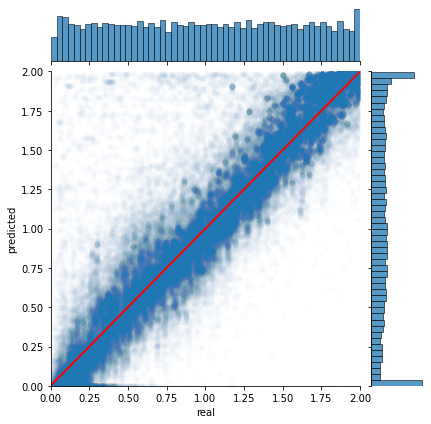

In [331]:
test_idx=full_generator.indexes
predicted=model2.predict_generator(full_generator)
predicted=[x[0] for x in predicted]
#predicted=[x/2 for x in predicted]
test_idx=test_idx[:len(predicted)]
test_df=pd.DataFrame({'real':NCI_ALMANAC_combination_sample.iloc[test_idx].PERCENTGROWTH,'predicted':predicted})
#(Softmax only)
test_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Result/221125_Full_scaled_with_monotherapy_without_FM/221125_test_df.csv')

plot=sns.jointplot(test_df.real,test_df.predicted,alpha=0.01)

plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plt.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/Result/221125_Full_scaled_with_monotherapy_without_FM/221125_NCI_ALMANAC_Full_with_monotherapy_scaled_without_FM.pdf')